## K-means+DTW

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
n_samples, n_timestamps = 100, 50
cluster_1 = np.sin(np.linspace(0, 4 * np.pi, n_timestamps)) + np.random.normal(0, 0.1, (25, n_timestamps))
cluster_2 = np.cos(np.linspace(0, 4 * np.pi, n_timestamps)) + np.random.normal(0, 0.1, (25, n_timestamps))
cluster_3 = np.sin(np.linspace(0, 8 * np.pi, n_timestamps)) + np.random.normal(0, 0.1, (25, n_timestamps))
cluster_4 = np.cos(np.linspace(0, 8 * np.pi, n_timestamps)) + np.random.normal(0, 0.1, (25, n_timestamps))

data = np.vstack([cluster_1, cluster_2, cluster_3, cluster_4])
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(data)

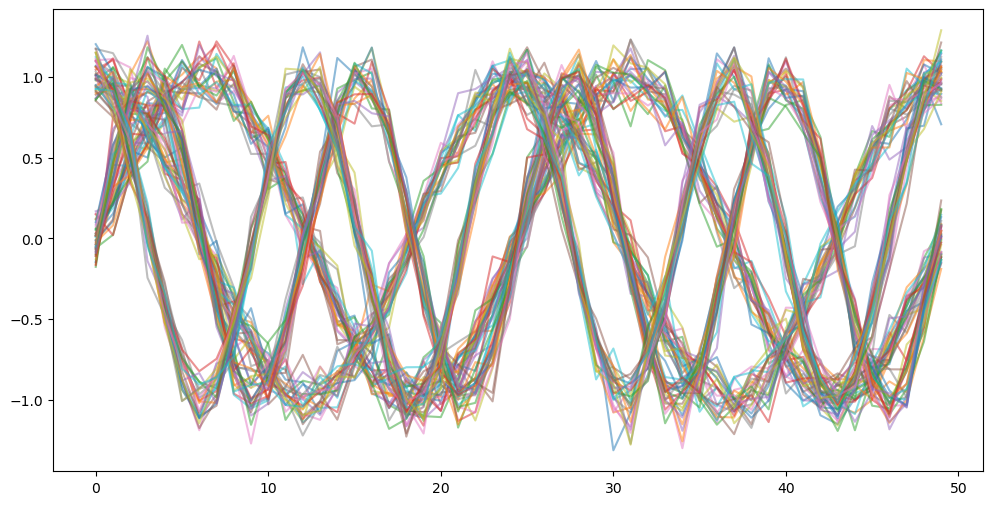

In [2]:
plt.figure(figsize=(12, 6))
for i, cluster in enumerate([cluster_1, cluster_2, cluster_3, cluster_4], 1):
    for series in cluster:
        plt.plot(series, alpha=0.5)
plt.show()

In [3]:
# K-means
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=50, random_state=42)
y_pred = model.fit_predict(data_scaled)
# 聚类中心
centroids = model.cluster_centers_

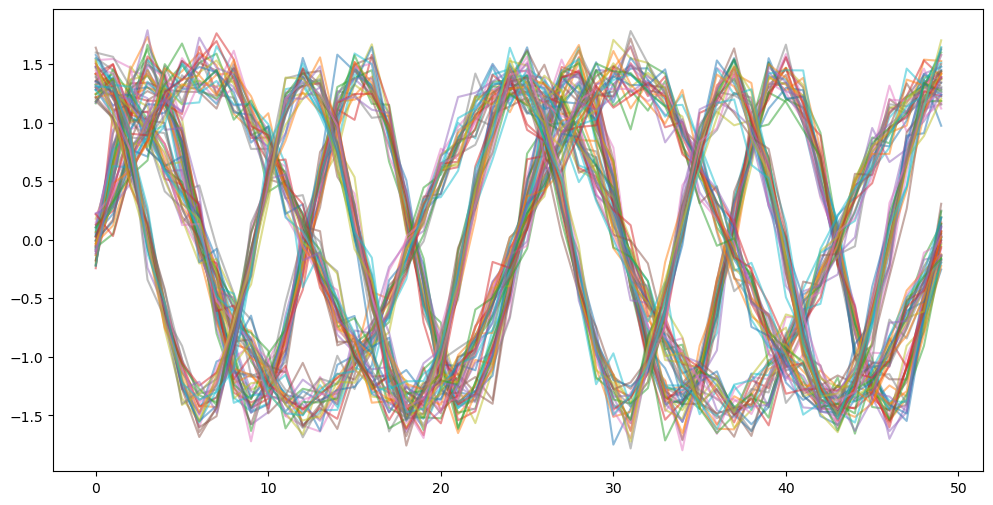

In [5]:
plt.figure(figsize=(12, 6))
for cluster_idx in range(4):
    cluster_data = data_scaled[y_pred == cluster_idx]
    for series in cluster_data:
        plt.plot(series.flatten(), alpha=0.5)
plt.show()

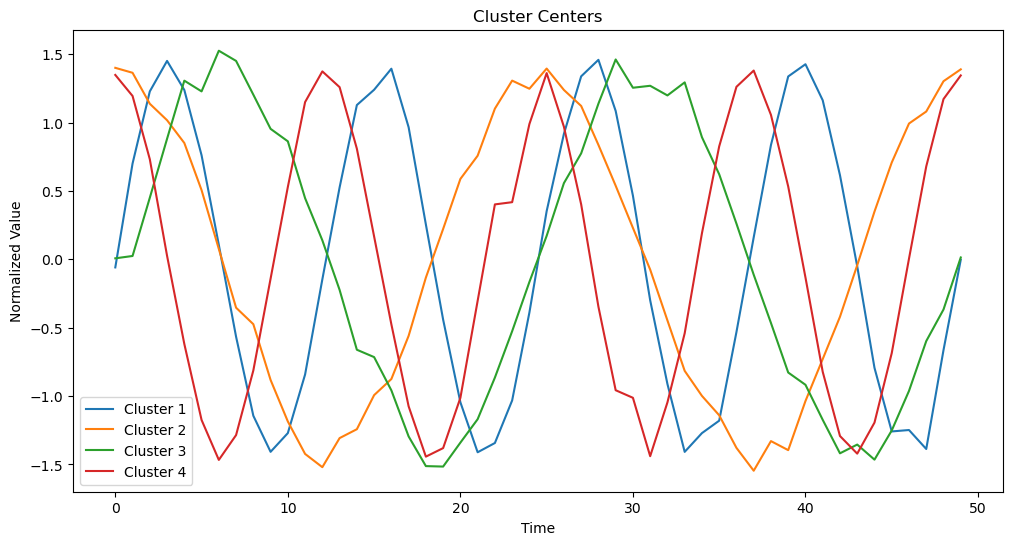

In [6]:
plt.figure(figsize=(12, 6))
for i, centroid in enumerate(centroids):
    plt.plot(centroid.flatten(), label=f"Cluster {i+1}")
plt.title("Cluster Centers")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

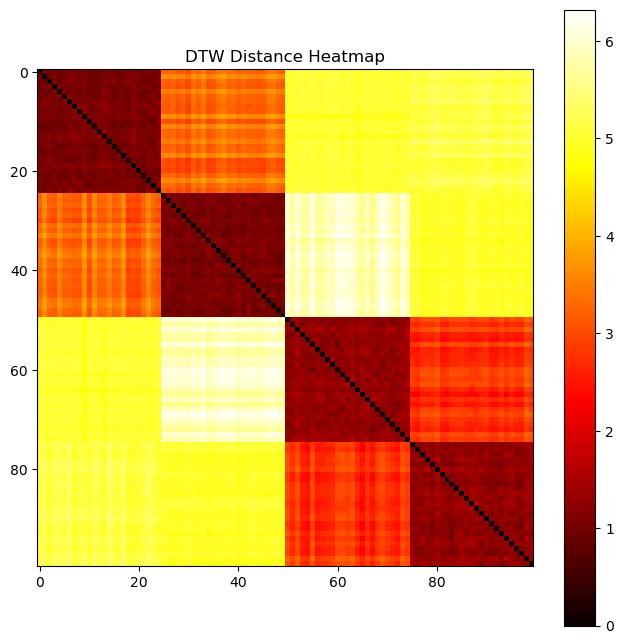

In [7]:
from tslearn.metrics import cdist_dtw

dist_matrix = cdist_dtw(data_scaled)
plt.figure(figsize=(8, 8))
plt.imshow(dist_matrix, cmap='hot', interpolation='nearest')
plt.title("DTW Distance Heatmap")
plt.colorbar()
plt.show()

## ARIMA+基于贝叶斯优化的LSTM

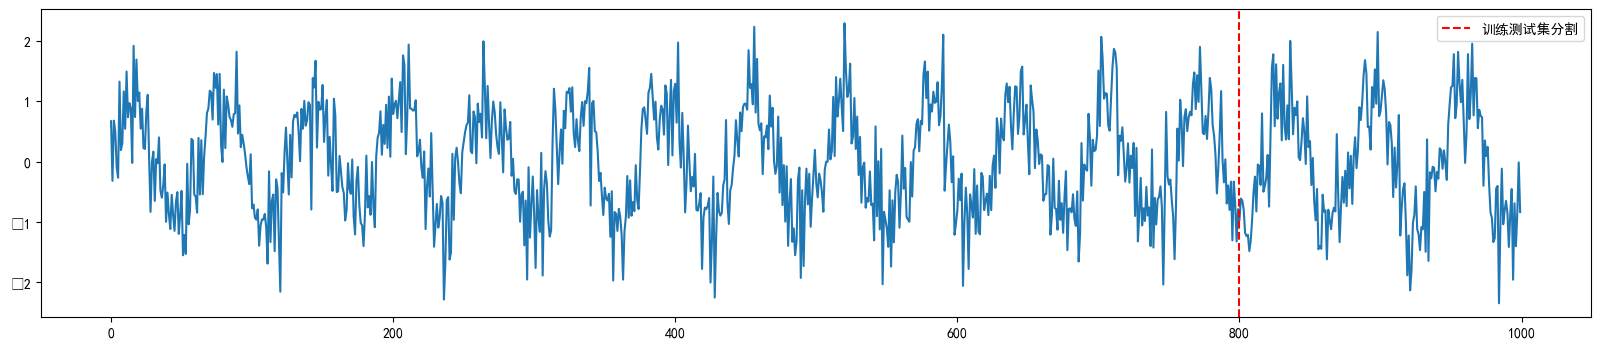

In [12]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
plt.rcParams['font.family'] = 'SimHei'
# 模拟数据（正弦波+随机噪声）
np.random.seed(3407)
time = np.arange(0, 100, 0.1)
data = np.sin(time) + 0.5 * np.random.normal(size=len(time))
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
plt.figure(figsize=(20,4))
plt.plot(data)
plt.axvline(train_size, color='red', linestyle='--', label='训练测试集分割')
plt.legend()
plt.show()

In [13]:
# ARIMA拟合
arima_model = ARIMA(train_data, order=(5, 1, 0)) 
arima_result = arima_model.fit()

# ARIMA预测值
arima_pred_train = arima_result.predict(start=1, end=len(train_data)-1)
arima_residuals = train_data[1:] - arima_pred_train  #残差

In [14]:
from bayes_opt import BayesianOptimization
scaler = MinMaxScaler(feature_range=(0, 1))
arima_residuals_scaled = scaler.fit_transform(arima_residuals.reshape(-1, 1))
def create_lstm_dataset(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 20
X_train, y_train = create_lstm_dataset(arima_residuals_scaled, time_steps)
def train_lstm(units, learning_rate, batch_size):
    units = int(units)
    batch_size = int(batch_size)
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=(time_steps, 1)),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=0)
    return -history.history['loss'][-1]

# 贝叶斯优化
pbounds = {
    'units': (10, 100), 
    'learning_rate': (1e-4, 1e-2), 
    'batch_size': (16, 128) 
}

optimizer = BayesianOptimization(
    f=train_lstm,
    pbounds=pbounds,
    random_state=42
)

# 贝叶斯优化
optimizer.maximize(init_points=5, n_iter=10)
print("最佳参数：", optimizer.max)

# 使用最佳参数训练
best_params = optimizer.max['params']
best_units = int(best_params['units'])
best_learning_rate = best_params['learning_rate']
best_batch_size = int(best_params['batch_size'])

final_model = Sequential([
    LSTM(best_units, activation='tanh', input_shape=(time_steps, 1)),
    Dense(1)
])
final_model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mae')
final_model.fit(X_train, y_train, epochs=20, batch_size=best_batch_size, verbose=1)

|   iter    |  target   | batch_... | learni... |   units   |
-------------------------------------------------------------


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 1         | -0.1239   | 57.95     | 0.009512  | 75.88     |
| 2         | -0.122    | 83.05     | 0.001645  | 24.04     |
| 3         | -0.1243   | 22.51     | 0.008675  | 64.1      |
| 4         | -0.1227   | 95.3      | 0.0003038 | 97.29     |
| 5         | -0.1234   | 109.2     | 0.002202  | 26.36     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 6         | -0.122    | 82.28     | 0.0008151 | 23.27     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 7         | -0.1236   | 76.31     | 0.003722  | 40.57     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 8         | -0.1222   | 90.52     | 0.009531  | 15.65     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 9         | -0.1225   | 124.6     | 0.0098    | 98.68     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 10        | -0.1222   | 124.4     | 0.002961  | 75.47     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 11        | -0.1229   | 106.1     | 0.003434  | 72.6      |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 12        | -0.1225   | 127.1     | 0.003155  | 56.68     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 13        | -0.1227   | 17.29     | 0.004207  | 10.05     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 14        | -0.1232   | 48.16     | 0.007353  | 10.44     |


C:\Users\huashuo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 15        | -0.1233   | 16.96     | 0.006833  | 99.42     |
最佳参数： {'target': -0.1220068484544754, 'params': {'batch_size': 83.0497502300681, 'learning_rate': 0.0016445845403801217, 'units': 24.03950683025824}}
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.36037
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1318 
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1229 
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1304 
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1200 
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1227 
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1231 
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1229 
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1217 
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1236 
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1234 
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


d:\dev\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


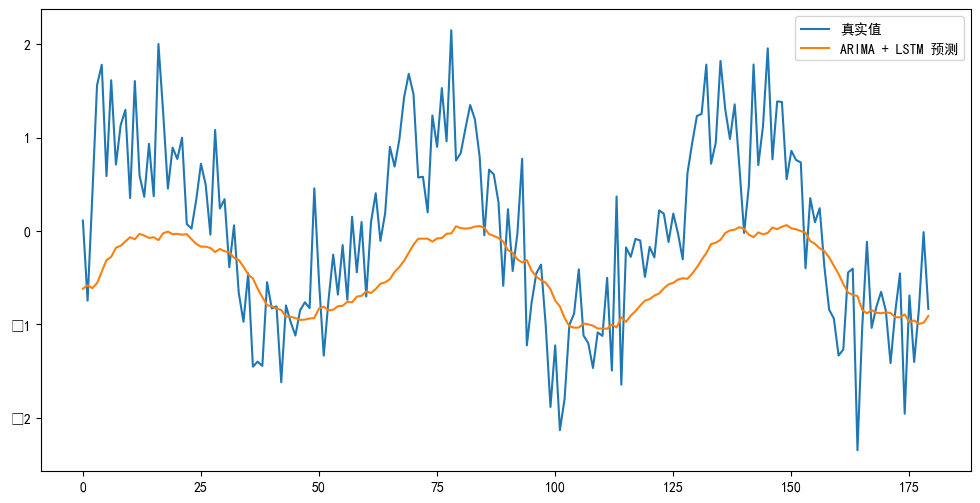

In [16]:
arima_pred_test = arima_result.predict(start=len(train_data), end=len(data)-1)
test_residuals = test_data - arima_pred_test
test_residuals_scaled = scaler.transform(test_residuals.reshape(-1, 1))
X_test, _ = create_lstm_dataset(test_residuals_scaled, time_steps)
lstm_pred = final_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
# 融合预测结果
final_pred = arima_pred_test[time_steps:] + lstm_pred.flatten()
plt.figure(figsize=(12, 6))
plt.plot(test_data[time_steps:], label='真实值')
plt.plot(final_pred, label='ARIMA + LSTM 预测')
plt.legend()
plt.show()